In [1]:
#Jillian Stoller last updated March 2021
from urllib import request
import re
import pandas as pd
import nltk
import numpy
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Obtain ebooks from Project Gutenberg

Gutenberg_TextFileHTMLs.csv is a csv that contains the url links to the top 100 most popular books's text files on Project Gutenberg. To obtain the ebooks text, we need to read the file, create a html list and then open each url from that list.

In [2]:
with open('Gutenberg_TextFileHTMLs.csv', 'r') as file:
    html_list = file.read().splitlines()

In [3]:
#function that uses the request library to open urls
def open_url(url):
    response = request.urlopen(url)
    raw = response.read()
    ebook = raw.decode("utf-8-sig")
    return ebook

In [4]:
#create a library list of all books in the url
library = []
for url in html_list:
    library.append(open_url(url))

In [5]:
#Display output for the first url in the html_list
book = library[0]
print(book)

The Project Gutenberg eBook of Frankenstein, by Mary Wollstonecraft (Godwin) Shelley

This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this eBook or online at
www.gutenberg.org. If you are not located in the United States, you
will have to check the laws of the country where you are located before
using this eBook.

Title: Frankenstein
       or, The Modern Prometheus

Author: Mary Wollstonecraft (Godwin) Shelley

Release Date: 31, 1993 [eBook #84]
[Most recently updated: November 13, 2020]

Language: English

Character set encoding: UTF-8

Produced by: Judith Boss, Christy Phillips, Lynn Hanninen, and David Meltzer. HTML version by Al Haines.
Further corrections by Menno de Leeuw.

*** START OF THE PROJECT GUTENBERG EBOOK FRANKENSTEIN ***




Frankenstein;

or, the Modern Prom

In [6]:
def FindTitle(library):
    
    book_List=[]
    
    for book in library:
        #Find the title
        
        #Parition "Title: " since the titles follow that string in the text file
        #take the following 100 characters bc we don't know title's char length 
        Long_Title = book.partition("Title: ")[2][0:100]
        #After the title, the char "\r" follows before the next information
        #so find "\r" to find the index position of the end of the title
        stopping_point = Long_Title.find("\r")
        #slice the long title to remove everything after the stopping point
        title = Long_Title[0:stopping_point]
        
        #Find the author
        
        #follow same logic, but with "Author: " as starting point
        Long_Author = book.partition("Author: ")[2][0:100]
        stopping_point = Long_Author.find("\r")
        author = Long_Author[0:stopping_point]
        
        #put both title & author together
        if author == "":
            author = "Unknown"
            
        information = title + " by " + author
        
        book_List.append(information)

    
    return book_List
    
Title_List = FindTitle(library)
Title_List

['Frankenstein by Mary Wollstonecraft (Godwin) Shelley',
 'Pride and Prejudice by Jane Austen',
 'The Great Gatsby by F. Scott Fitzgerald',
 'A Modest Proposal by Jonathan Swift',
 'A Tale of Two Cities by Charles Dickens',
 'A Doll’s House by Henrik Ibsen',
 'Alice’s Adventures in Wonderland by Lewis Carroll',
 'The Importance of Being Earnest by Oscar Wilde',
 'Metamorphosis by Franz Kafka',
 'Moby-Dick; or The Whale by Herman Melville',
 'Adventures of Huckleberry Finn by Mark Twain (Samuel Clemens)',
 'The Strange Case Of Dr. Jekyll And Mr. Hyde by Robert Louis Stevenson',
 'The Picture of Dorian Gray by Oscar Wilde',
 'Jane Eyre by Charlotte Brontë',
 'The Scarlet Letter by Nathaniel Hawthorne',
 'The Adventures of Sherlock Holmes by Arthur Conan Doyle',
 'Heart of Darkness by Joseph Conrad',
 'The Yellow Wallpaper by Charlotte Perkins Gilman',
 'Great Expectations by Charles Dickens',
 'The Awakening and Selected Short Stories by Kate Chopin',
 'Anthem by Ayn Rand',
 'A Christmas

# Cleaning the Text Documents

There is a lot of data cleaning that needs to be done to remove all of the non-relevant characters. 
The first step is removing all of the front matter and end information. It appears that there is a signifier 
"*** START OF THE PROJECT GUTENVERG EBOOK TITLE ***"
To remove everything before this, we can use .strip("***" ) 

In [7]:
#we are choosing 2 because the book's text is in the third position, after the title matter and after the start of the project
#This also conveinently removes the end matter since there is another "***" at end of the book
book = book.split("***")[2]
print(book)






Frankenstein;

or, the Modern Prometheus

by Mary Wollstonecraft (Godwin) Shelley


 CONTENTS

 Letter 1
 Letter 2
 Letter 3
 Letter 4
 Chapter 1
 Chapter 2
 Chapter 3
 Chapter 4
 Chapter 5
 Chapter 6
 Chapter 7
 Chapter 8
 Chapter 9
 Chapter 10
 Chapter 11
 Chapter 12
 Chapter 13
 Chapter 14
 Chapter 15
 Chapter 16
 Chapter 17
 Chapter 18
 Chapter 19
 Chapter 20
 Chapter 21
 Chapter 22
 Chapter 23
 Chapter 24




Letter 1

_To Mrs. Saville, England._


St. Petersburgh, Dec. 11th, 17—.


You will rejoice to hear that no disaster has accompanied the
commencement of an enterprise which you have regarded with such evil
forebodings. I arrived here yesterday, and my first task is to assure
my dear sister of my welfare and increasing confidence in the success
of my undertaking.

I am already far north of London, and as I walk in the streets of
Petersburgh, I feel a cold northern breeze play upon my cheeks, which
braces my nerves and fills me with delight. Do you understand this
feeling?

Because not every book starts the same way and I want to keep the book title and the autor, I will not remove any more of the front matter. Now we can build the document corpus.

In [8]:
corpus = []
#loop through the html_list
for book in library:
    #remove front and end matter separated by "***"
    book = book.split("***")[2]
    corpus.append(book)


In [9]:
def CleanwStopWords(Doc_Corpus):
    
    #Obtain list of stop words from nltk.corpus library
    from nltk.corpus import stopwords
    #make stopwords a global variable so we can reference it in other functions
    global stopwords
    stopwords = stopwords.words('english')
    
    #create cleaned document corpus/ master list of document contents without stop words 
    cleaned_corpus = []
    doc_number = 0

    for doc in Doc_Corpus:
        #use the regular expression library
        #subsitute all non-alphabetical characters to spaces
        #make it all lowercase
        doc = re.sub("[^a-zA-Z]", ' ', doc.lower())
  
        #compile a list of all the words in the doc
        wordList = doc.split()

        #filter words from the wordlist that are not included in the stop words document
        filtered_words = [w for w in wordList if w not in stopwords]
    
        #apply stemming algorithm to obtain stems of from the word list
        global ps #make global to reference in query
        ps = PorterStemmer()
        stemmed = [ps.stem(w) for w in filtered_words] 
           
        #create new cleaned version of the doc with only the filtered, stemmed words
        clean_doc = ""
        for word in stemmed:
            clean_doc += word + " "
        
        #append the cleaned doc to corpus master doc list
        cleaned_corpus.append(clean_doc)
        
    return cleaned_corpus
    

In [10]:
cleaned_corpus = CleanwStopWords(corpus)
#a view how the stemming & stop words have changed the text
cleaned_corpus[0][500:1000]

'r north london walk street petersburgh feel cold northern breez play upon cheek brace nerv fill delight understand feel breez travel region toward advanc give foretast ici clime inspirit wind promis daydream becom fervent vivid tri vain persuad pole seat frost desol ever present imagin region beauti delight margaret sun ever visibl broad disk skirt horizon diffus perpetu splendour leav sister put trust preced navig snow frost banish sail calm sea may waft land surpass wonder beauti everi region '

In [11]:
#Checking the average length of each doc in the corpus
size = 0
count = 0
for book in cleaned_corpus:
    size += len(book)
    count += 1

(size/count)
    

232254.40740740742

# Creating the TFxIDF Weighted Inverted Matrix

In [12]:
def WeightedInvertedIndex(cleaned_corpus):
   
    #use TfidfVectorizer to convert a collection of documents to a matrix of token tfxidf weights
    #apply TfidfVectorizer to the stopwords
    global tf #make this global to reference for the query function
    tf = TfidfVectorizer(stopwords)

    #fit the TfidfVectorizer to the first document
    global tf_matrix #make this global to reference for the query function
    tf_matrix = tf.fit_transform(cleaned_corpus)
    
    #create dataframe out of all the feature names
    Terms_df = pd.DataFrame(tf.get_feature_names(), columns = ["Term"])
    
    #create data frame from the tf_matric. Transpose to align with corresponding feature name
    Lists_df= pd.DataFrame(tf_matrix.A).T
    
    #create column that sums all document frequencies to gather Total Occurance
    Lists_df['Total Occurance'] = Lists_df.sum(axis=1)
    
    #Concatinate the Feature Names and tf_matrix in an easy to read format
    Weighted_Inverted_Index_Table = pd.concat([Terms_df, Lists_df], axis=1)
    
    return Weighted_Inverted_Index_Table


In [13]:
#apply the weighted inverted index table to the cleaned corpus
Weighted_Inverted_Index_Table = WeightedInvertedIndex(cleaned_corpus)
Weighted_Inverted_Index_Table

,Term,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,Total Occurance
0,aaa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.002152
1,aaaaaah,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.001968
2,aaah,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.001968
3,aaarh,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.002152
4,aagj,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.006505,0.0,0.0,0.006505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75162,zwijgen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000320
75163,zwin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.002400
75164,zwoer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000320
75165,zy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.015941


In [14]:
#export Inverted Matrix for offline access
tf_matrix_df = pd.DataFrame(tf_matrix,columns=['Posting'])
tf_matrix_df.to_csv('tf_matrix.csv', index=False)

# Exploring the heaviest weighted words

Created function that takes in a title, the title list from above, and the weighted inverted index table to display the top 25 most heavily weighted words

In [15]:
def TopTerms():
    
    Title = input("Enter the title of a book: ")
    
    NumofTerms = input("How many of the top terms would you like to view? ")
    
    #check the Title List to see if the book is in our system
    if Title in Title_List:
        
        #find the index of the book based on the title list
        book_number = Title_List.index(Title)
        
        #subset the Weighted Inverted Index table to just get the information for the relevant book
        subset_table = Weighted_Inverted_Index_Table[["Term",book_number]]
        
        #rename subset_table's column names
        subset_table.columns = ['Stemmed Term', 'Weight']
        
        #sort the table to find the highest weights/most important non-common words
        sorted_table = subset_table.sort_values(by=['Weight'], ascending=False)
        
        #reduce the size of the table to the number of terms requested
        mini_sorted_table = sorted_table.iloc[0:int(NumofTerms),]
        
        #drop table's original index and replace it with a numbered one for readability
        mini_sorted_table = mini_sorted_table.reset_index(drop = True)
        mini_sorted_table.index += 1
       
        return mini_sorted_table
    
    else:
        print("That book is not in this library.")

In [16]:
TopTerms()

Enter the title of a book: The Great Gatsby by F. Scott Fitzgerald
How many of the top terms would you like to view? 5


,Stemmed Term,Weight
1,gatsbi,0.726840
2,daisi,0.296520
3,tom,0.207795
4,jordan,0.135339
5,said,0.128601


These functions generate a word cloud to further visualize the words

In [17]:
def plot_wordcloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

In [18]:
def PlotWordCloud():
    
    Title = input("Enter the title of a book that you'd like to view in a word cloud: ")
    
    #check the Title List to see if the book is in our system
    if Title in Title_List:
        
        #find the index of the book based on the title list
        book_number = Title_List.index(Title)
        
        text = cleaned_corpus[book_number]
        
        #build the wordcloud - no need for stop words bc already removed        
        wordcloud = WordCloud().generate(text) 
        
        plot_wordcloud(wordcloud)
        
    
    else:
        print("That book is not in this library.")
        

Enter the title of a book that you'd like to view in a word cloud: The Great Gatsby by F. Scott Fitzgerald


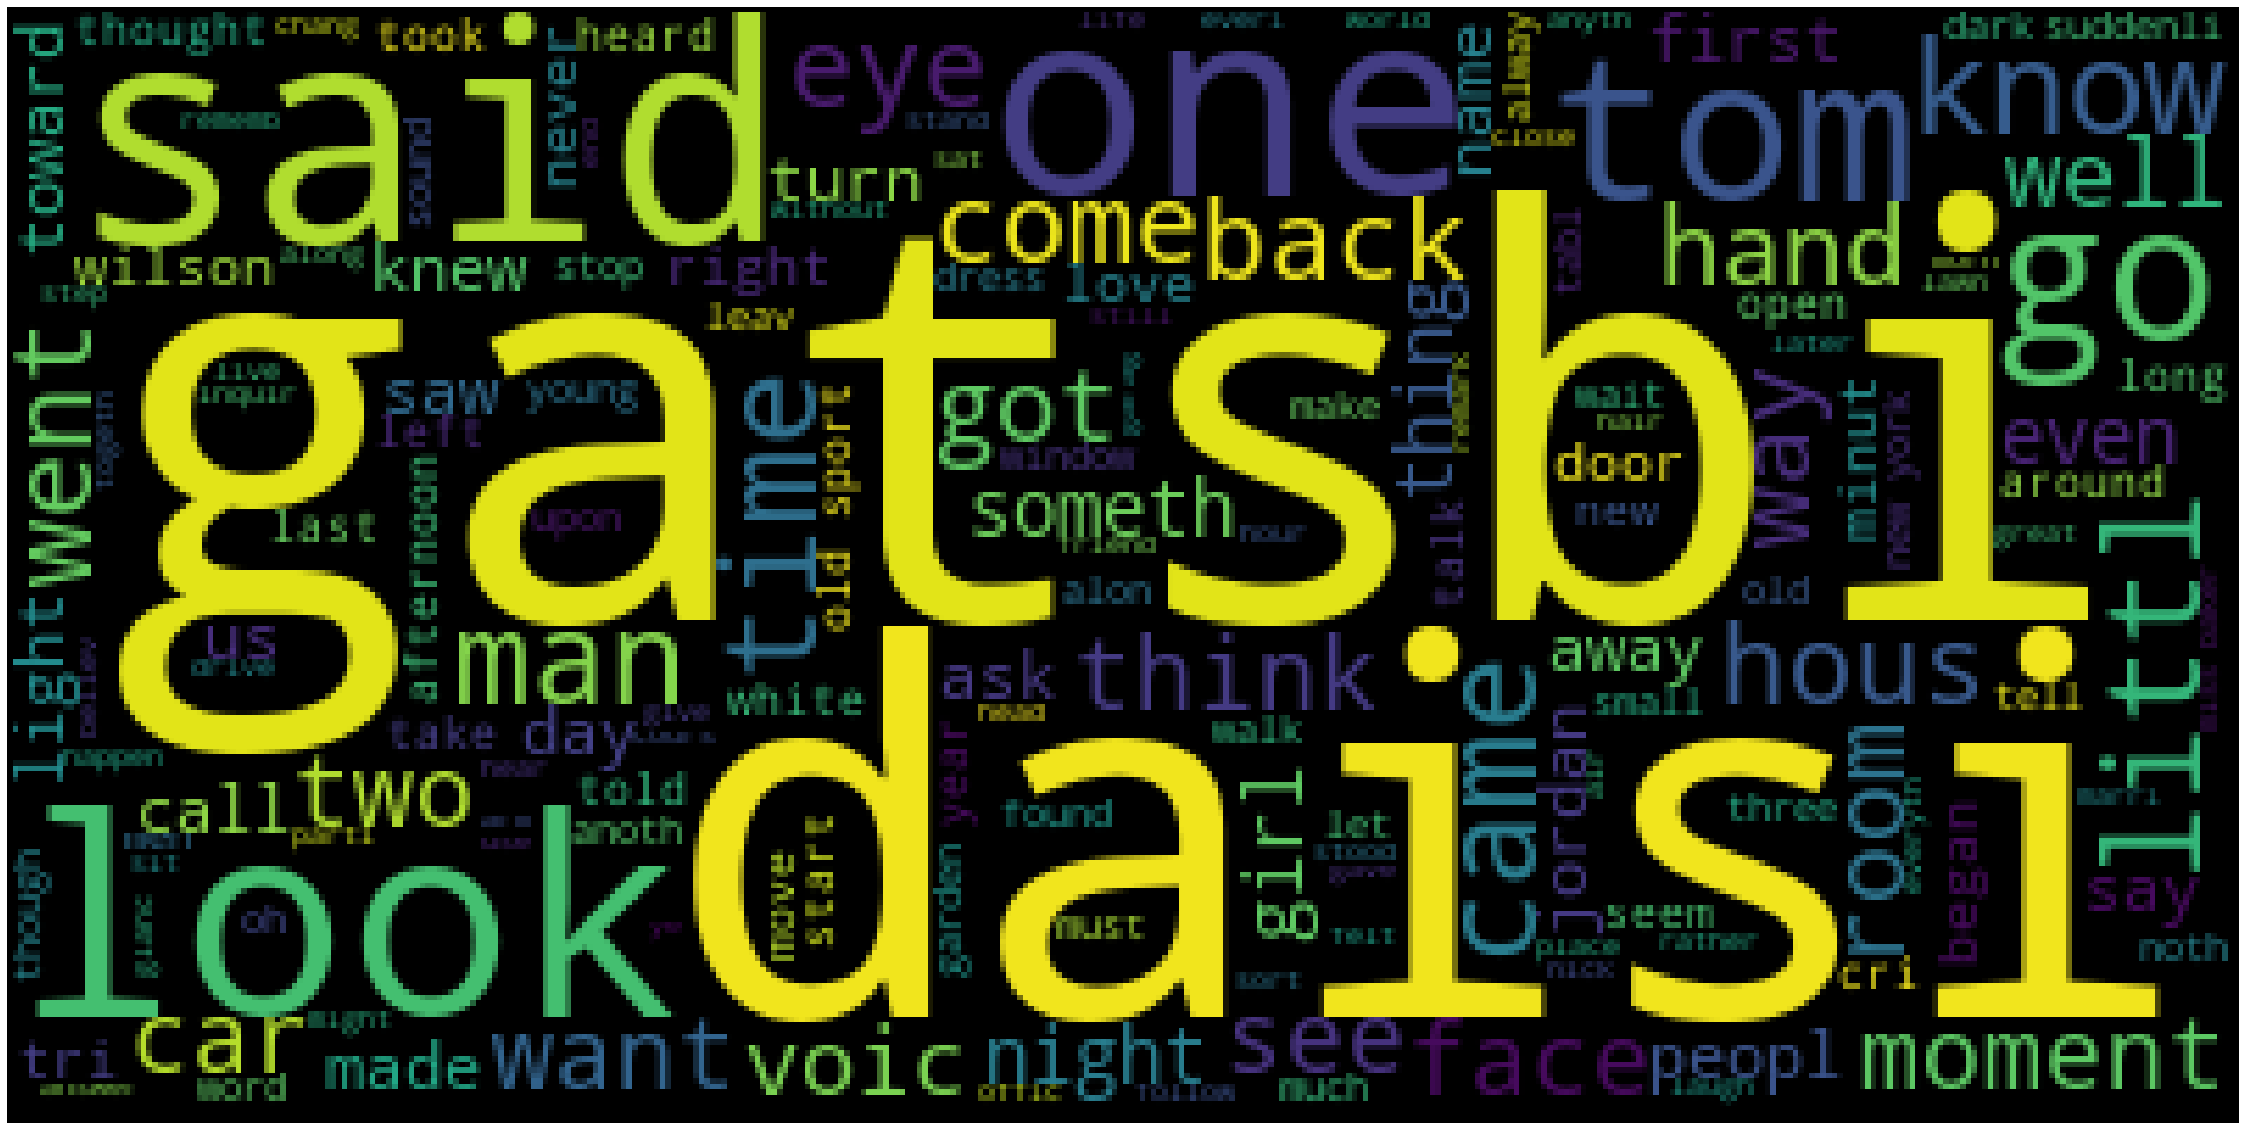

In [19]:
PlotWordCloud()

# Querying

In [20]:
def QuerySearch():
    
    #get query input from the user 
    query = input("Enter a phrase to search: ")
    
    from nltk.corpus import stopwords #bring in English stopwords
    stopwords = stopwords.words('english')
    
    #clean the query similarly to how the corpus was cleaned
    query = re.sub("[^a-zA-Z]", ' ', query.lower())
    
    #compile a list of all the words in the doc
    wordList = query.split()

    #filter words from the wordlist that are not included in the stop words document
    filtered_words = [w for w in wordList if w not in stopwords]
    
    #apply stemming algorithm to obtain stems of from the word list
    stemmed = [ps.stem(w) for w in filtered_words]
    
    query_cleaned = ""
    for word in stemmed:
        query_cleaned += word + " "
        
    
    #apply the tfxidf transformation to the query
    query_vec = tf.transform([query_cleaned])
    
    #use cosine_similarity compared to the tf_matrix -- weighted inverted index matrix & the query
    results = cosine_similarity(tf_matrix,query_vec).reshape((-1,))
    
    #store results in a dictionary
    results_dict = {"Title":Title_List, "Link":html_list, "Cosine Similarity":results}
    
    #create a dataframe from the results dictionary
    results_table = pd.DataFrame(results_dict)
    
    #sort the table by highest cosine similarity scores
    results_table= results_table.sort_values(by=["Cosine Similarity"], ascending=False)
    
    #count how many results there will be
    #0 will always be a result so subtract 1 to only see values greater than 0
    results_number = len(results_table["Cosine Similarity"].value_counts()) - 1
    
    #only show the top results by slicing only values that are greater than 0
    if results_number <10:
        top_results = results_table.iloc[0:results_number,]
    else:
        top_results = results_table.iloc[0:10,]
    
    #drop original index and replace it with its own
    top_results = top_results.reset_index(drop = True)
    
    #add 1 to the index to be more human friendly
    top_results.index += 1


    return top_results

In [33]:
QuerySearch()

Enter a phrase to search: “She had wandered, without rule or guidance, into a moral wilderness. Her intellect and heart had their home, as it were, in desert places, where she roamed as freely as the wild Indian in his woods. The scarlet letter was her passport into regions where other women dared not tread. Shame, Despair, Solitude! These had been her teachers - stern and wild ones - and they had made her strong, but taught her much amiss.”


,Title,Link,Cosine Similarity
1,Walden by Henry David Thoreau,https://www.gutenberg.org/files/205/205-0.txt,0.108106
2,The Scarlet Letter by Nathaniel Hawthorne,https://www.gutenberg.org/files/25344/25344-0.txt,0.091245
3,Frankenstein by Mary Wollstonecraft (Godwin) S...,https://www.gutenberg.org/files/84/84-0.txt,0.089428
4,"The Essays of Montaigne, Complete by Michel de...",https://www.gutenberg.org/files/3600/3600-0.txt,0.088590
5,The Life and Adventures of Robinson Crusoe by ...,https://www.gutenberg.org/files/521/521-0.txt,0.087502
6,The Clerk of the Woods by Bradford Torrey,https://www.gutenberg.org/files/64727/64727-0.txt,0.084307
7,Anthem by Ayn Rand,https://www.gutenberg.org/files/1250/1250-0.txt,0.083139
8,The Devil's Dictionary by Ambrose Bierce,https://www.gutenberg.org/cache/epub/972/pg972...,0.083123
9,Autobiography of Benjamin Franklin by Benjamin...,https://www.gutenberg.org/cache/epub/20203/pg2...,0.079670
10,Jane Eyre by Charlotte Brontë,https://www.gutenberg.org/files/1260/1260-0.txt,0.076902


# Recommending Similar Books

In [22]:
def RecommendSearch():
    
    #get query input from the user 
    book = input("Enter a book you really enjoy: ")
    
    index = Title_List.index(book)
    
    book_text = [cleaned_corpus[index]]
    
    
    #apply the tfxidf tranfromation to the query
    book_query_vec = tf.transform(book_text)
    
    #use cosine_similarity compared to the tf_matrix -- weighted inverted index matrix & the query
    results = cosine_similarity(tf_matrix,book_query_vec).reshape((-1,))
    
    #store results in a dictionary
    results_dict = {"Title":Title_List, "Link":html_list, "Cosine Similarity":results}
    
    #create a dataframe from the results dictionary
    results_table = pd.DataFrame(results_dict)
    
    #sort the table by highest cosine similarity scores
    results_table= results_table.sort_values(by=["Cosine Similarity"], ascending=False)
    
    #count how many results there will be
    #0 will always be a result so subtract 1 to only see values greater than 0
    results_number = len(results_table["Cosine Similarity"].value_counts()) - 1
    
    #only show the top results by slicing only values that are greater than 0
    if results_number <11:
        top_results = results_table.iloc[1:results_number,]
    else:
        top_results = results_table.iloc[1:11,]
    
    #drop original index and replace it with its own
    top_results = top_results.reset_index(drop = True)
    
    #add 1 to the index to be more human friendly
    top_results.index += 1


    return top_results

In [30]:
RecommendSearch()

Enter a book you really enjoy: A Tale of Two Cities by Charles Dickens


,Title,Link,Cosine Similarity
1,Jane Eyre by Charlotte Brontë,https://www.gutenberg.org/files/1260/1260-0.txt,0.434542
2,Dubliners by James Joyce,https://www.gutenberg.org/files/2814/2814-0.txt,0.425250
3,The Adventures of Sherlock Holmes by Arthur Co...,https://www.gutenberg.org/files/1661/1661-0.txt,0.408253
4,Grimms’ Fairy Tales by The Brothers Grimm,https://www.gutenberg.org/files/2591/2591-0.txt,0.400837
5,Ulysses by James Joyce,https://www.gutenberg.org/files/4300/4300-0.txt,0.396913
6,The Life and Adventures of Robinson Crusoe by ...,https://www.gutenberg.org/files/521/521-0.txt,0.387945
7,Treasure Island by Robert Louis Stevenson,https://www.gutenberg.org/files/120/120-0.txt,0.381853
8,Walden by Henry David Thoreau,https://www.gutenberg.org/files/205/205-0.txt,0.380745
9,The Interesting Narrative of the Life of Olaud...,https://www.gutenberg.org/cache/epub/15399/pg1...,0.378156
10,Dracula by Bram Stoker,https://www.gutenberg.org/files/345/345-0.txt,0.377618
